Resources:
https://www.mdpi.com/2077-0472/8/5/70
https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/use-cases/coastal-erosion-example/

In [84]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.util import view_as_windows


In [48]:
skimage.feature

<module 'skimage.feature' from '/Users/kevinlacaille/.pyenv/versions/3.11.4/envs/scipy2024-env/lib/python3.11/site-packages/skimage/feature/__init__.py'>

In [49]:
# Function to display a single band
def display_band(band, title, cmap='gray', colour_bar=False):
    plt.figure(figsize=(6, 6))
    plt.imshow(band, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    if colour_bar:
        plt.colorbar()
    plt.show()

In [50]:
# Path to the image file
image_path = '8928dec4ddbffff/DJI_0876.JPG'

# Open the image file using rasterio
with rasterio.open(image_path) as src:
    blue = src.read(1)
    green = src.read(2)
    red = src.read(3)


/Users/kevinlacaille/.pyenv/versions/3.11.4/envs/scipy2024-env/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


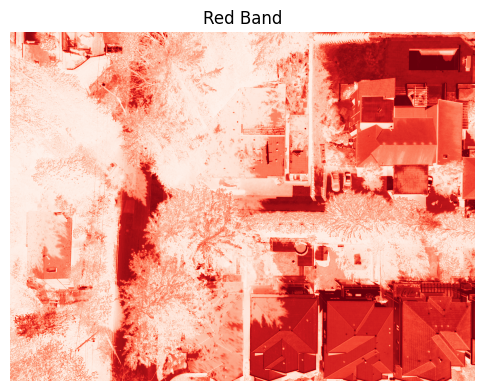

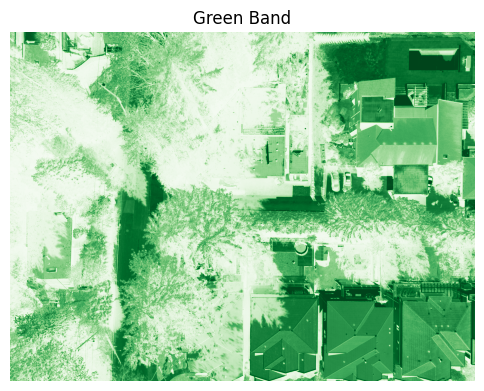

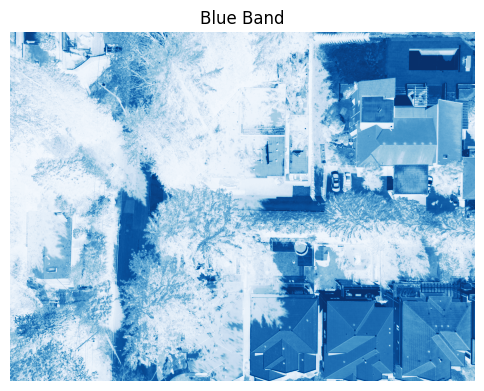

In [51]:
# Display the R, G, B bands
display_band(red, 'Red Band', cmap='Reds')
display_band(green, 'Green Band', cmap='Greens')
display_band(blue, 'Blue Band', cmap='Blues')


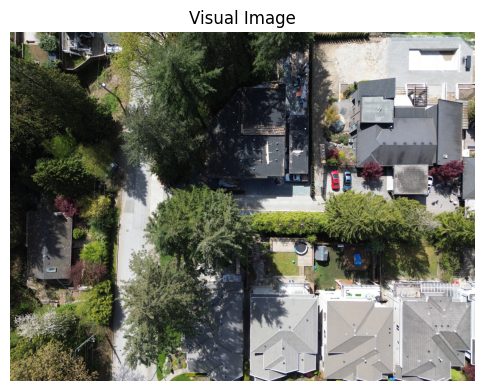

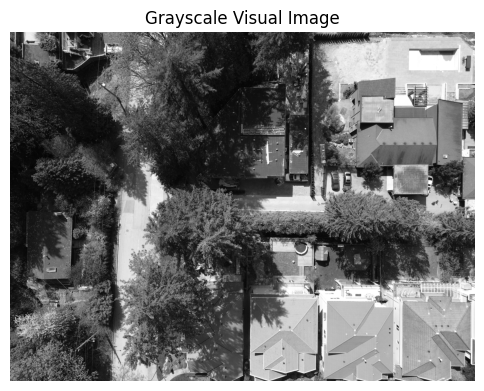

In [52]:
# To construct a visual image, we will need the red, green, and blue bands
visual_image = np.dstack((blue, green, red))
display_band(visual_image, 'Visual Image')
# To construct a visual image, we will need the red, green, and blue bands
visual_image_gray = cv2.cvtColor(visual_image, cv2.COLOR_BGR2GRAY)
display_band(visual_image_gray, 'Grayscale Visual Image', cmap='gray')

In [53]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

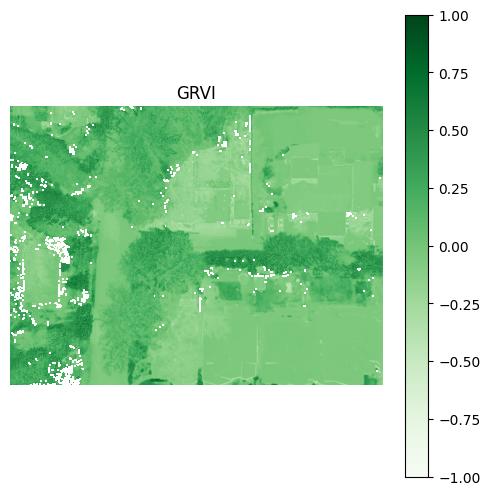

In [54]:
# Calculate Green Red Vegetation Index (GRVI)
grvi = (green.astype(float) - 1.1 * red.astype(float)) / (
    green.astype(float) + 1.1 * red.astype(float))
display_band(grvi, 'GRVI', cmap='Greens', colour_bar=True)

In [55]:
green_mask = np.full(grvi.shape, np.nan)
land_mask = np.full(grvi.shape, np.nan)

green_mask[grvi >= 0] = 1
land_mask[grvi < 0] = 1

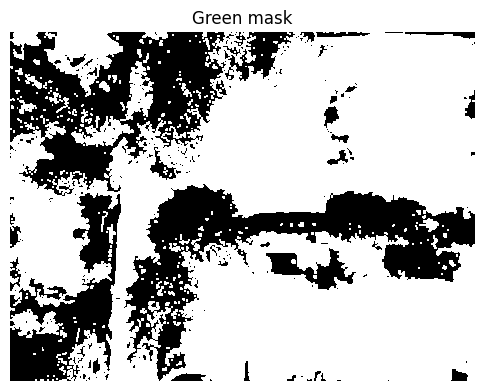

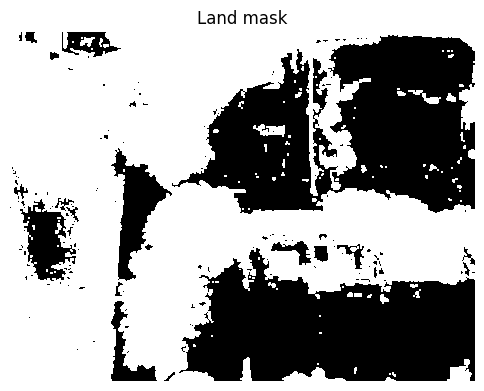

In [56]:
display_band(green_mask, 'Green mask')
display_band(land_mask, 'Land mask')

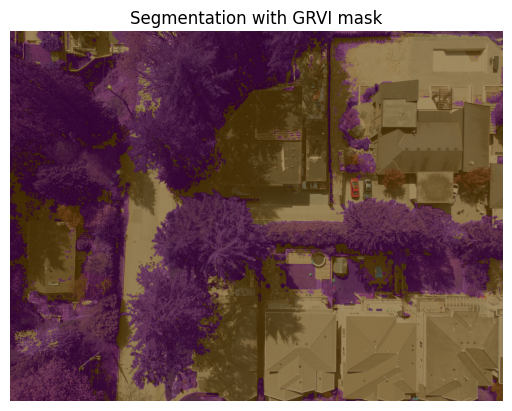

In [57]:
# Create a mask overlay with gray color
green_mask_overlay = np.zeros_like(visual_image)
green_mask_overlay[:, :, 0] = 128  # Red channel for gray
green_mask_overlay[:, :, 1] = 0  # Green channel for gray
green_mask_overlay[:, :, 2] = 128  # Blue channel for gray

# Apply the green mask to the mask overlay
g_mask = np.isnan(green_mask)
green_mask_overlay[g_mask] = [0, 0, 0]  # Transparent where mask is not applied

land_mask_overlay = np.zeros_like(visual_image)
land_mask_overlay[:, :, 0] = 255  # Red channel for gray
land_mask_overlay[:, :, 1] = 165  # Green channel for gray
land_mask_overlay[:, :, 2] = 0  # Blue channel for gray

# Apply the green mask to the mask overlay
l_mask = np.isnan(land_mask)
land_mask_overlay[l_mask] = [0, 0, 0]  # Transparent where mask is not applied

# Display the visual image
plt.imshow(visual_image)
plt.title("Segmentation with GRVI mask")

# Overlay the mask with 50% transparency
plt.imshow(green_mask_overlay, alpha=0.5)
plt.imshow(land_mask_overlay, alpha=0.25)
plt.axis('off')
plt.show()


In [58]:
# count number of pixels in green_mask
green_pixels = np.nansum(green_mask)

# count total pixels
total_pixels = red.size

N_PIXELS_PER_TREE = 500000
n_trees = green_pixels / N_PIXELS_PER_TREE
print(f'Number of trees: {n_trees:.0f}')


Number of trees: 11


In [59]:
# CO2 absorbed per tree in kg (https://ecotree.green/en/how-much-co2-does-a-tree-absorb#:~:text=A%20tree%20absorbs%20approximately%2025kg%20of%20CO2%20per%20year&text=But%20really%20a%20tree%20absorbs,a%20tree%20absorbs%20so%20interesting.)
carbon_absorbed_per_tree = 25

In [60]:
# Calculate the amount of carbon absorbed by the trees
carbon_absorbed = n_trees * carbon_absorbed_per_tree
print(f'Amount of carbon absorbed: {carbon_absorbed:.0f} kg')

Amount of carbon absorbed: 284 kg


In [62]:
# kernel size for empty pixels within the mask
closing_kernel_size = 40  # kernel size for filled pixels inside of mask
opening_kernel_size = 15  # kernel size for empty pixels outside of mask

# Apply closing filter (remove false negatives)
closing_kernel_element = (closing_kernel_size, closing_kernel_size)
closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                           closing_kernel_element)
green_closed = cv2.morphologyEx(np.nan_to_num(green_mask), cv2.MORPH_CLOSE,
                                closing_kernel)

# Apply opening filter (removing false positives)
opening_kernel_element = (opening_kernel_size, opening_kernel_size)
opening_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,
                                           opening_kernel_element)
green_closed_opened = cv2.morphologyEx(green_closed, cv2.MORPH_OPEN,
                                       opening_kernel)

# Ensure the clipped areas remain clipped
green_closed_opened[green_closed_opened == 0] = np.nan

green_mask_filtered = green_closed_opened


In [63]:
# make land mask filtered as the opposite of green mask filtered
land_mask_filtered = np.full(green_mask_filtered.shape, np.nan)
land_mask_filtered[green_mask_filtered == np.nan] = 5
land_mask_filtered[green_mask_filtered == 1] = np.nan

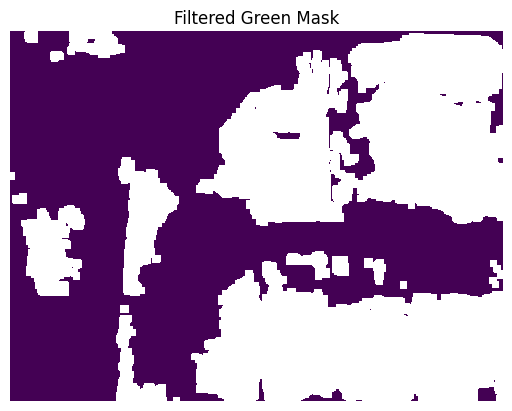

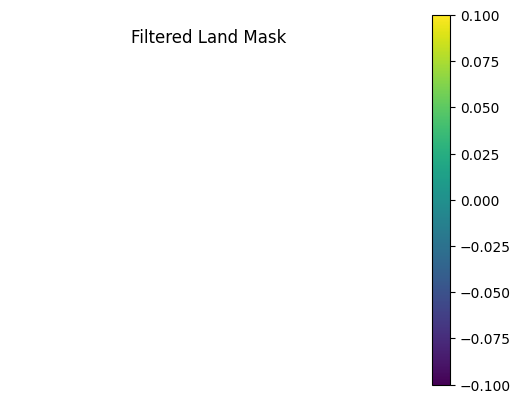

In [64]:
plt.imshow(green_mask_filtered)
plt.title("Filtered Green Mask")
plt.axis('off')
plt.show()

plt.imshow(land_mask_filtered)
plt.title("Filtered Land Mask")
plt.axis('off')
plt.colorbar()
plt.show()

In [65]:
# Create a mask overlay with gray color
green_mask_overlay = np.zeros_like(visual_image)
green_mask_overlay[:, :, 0] = 128  # Red channel for gray
green_mask_overlay[:, :, 1] = 0  # Green channel for gray
green_mask_overlay[:, :, 2] = 128  # Blue channel for gray

# Apply the green mask to the mask overlay
g_mask = np.isnan(green_mask_filtered)
green_mask_overlay[g_mask] = [0, 0, 0]  # Transparent where mask is not applied

land_mask_overlay = np.zeros_like(visual_image)
land_mask_overlay[:, :, 0] = 255  # Red channel for gray
land_mask_overlay[:, :, 1] = 165  # Green channel for gray
land_mask_overlay[:, :, 2] = 0  # Blue channel for gray

# Apply the green mask to the mask overlay
l_mask = np.isnan(land_mask_filtered)
land_mask_overlay[l_mask] = [0, 0, 0]  # Transparent where mask is not applied

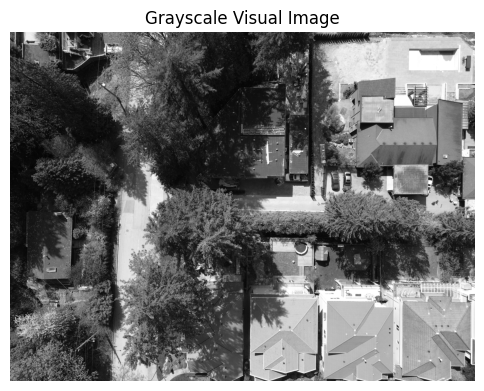

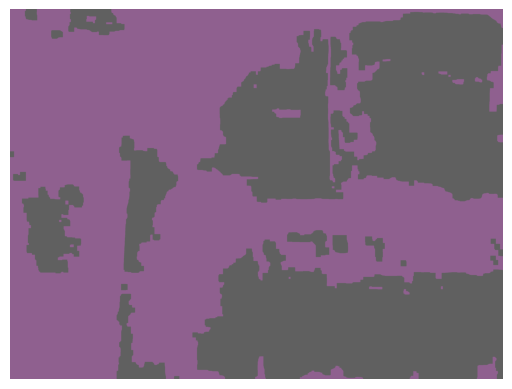

In [66]:
# Display the visual image
visual_image_gray = cv2.cvtColor(visual_image, cv2.COLOR_BGR2GRAY)
display_band(visual_image_gray, 'Grayscale Visual Image', cmap='gray')

# Overlay the mask with 50% transparency
plt.imshow(green_mask_overlay, alpha=0.5)
plt.imshow(land_mask_overlay, alpha=0.25)
plt.axis('off')
plt.show()

In [67]:
# Threshold the green mask to create a binary mask
binary_mask = np.where(green_mask == 1, 1, 0).astype(np.uint8)

# Perform connected components analysis with stats
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(
    binary_mask)

# Define size thresholds
min_size = 1000
max_size = 9000000

# Filter out small and large components
filtered_mask = np.zeros_like(binary_mask)
for label in range(1, num_labels):
    area = stats[label, cv2.CC_STAT_AREA]
    if min_size <= area <= max_size:
        filtered_mask[labels_im == label] = 1

# Create a mask overlay with purple color (Red + Blue)
mask_overlay = np.zeros_like(visual_image)
mask_overlay[:, :, 0] = 128  # Red channel for purple
mask_overlay[:, :, 1] = 0  # Green channel for purple
mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the filtered mask to the mask overlay
mask_overlay[filtered_mask == 0] = [0, 0,
                                    0]  # Transparent where mask is not applied


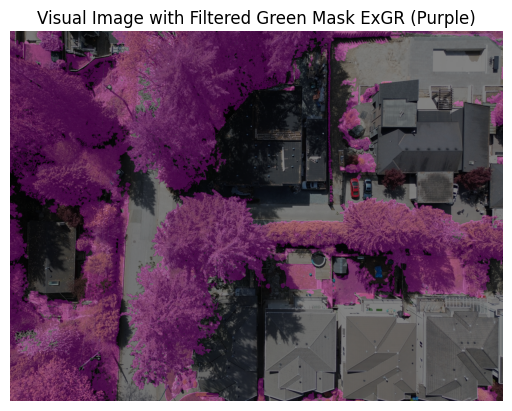

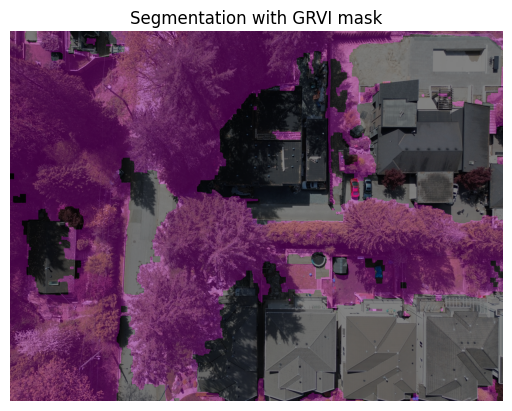

In [68]:
# Display the visual image
plt.imshow(visual_image)
plt.title("Visual Image with Filtered Green Mask ExGR (Purple)")

# Overlay the mask with 50% transparency
plt.imshow(mask_overlay, alpha=0.5)

# Show the plot
plt.axis('off')
plt.show()

# Display the visual image
plt.imshow(visual_image)
plt.title("Segmentation with GRVI mask")

# Overlay the mask with 50% transparency
plt.imshow(green_mask_overlay, alpha=0.5)
plt.axis('off')
plt.show()

In [69]:
# Apply morphological opening to remove small objects
kernel = np.ones((100, 100), np.uint8)
# Apply morphological closing to fill small holes
closed_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_CLOSE, kernel)
opened_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)

# Create a mask overlay with purple color (Red + Blue)
mask_overlay = np.zeros_like(visual_image)
mask_overlay[:, :, 0] = 128  # Red channel for purple
mask_overlay[:, :, 1] = 0  # Green channel for purple
mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the filtered mask to the mask overlay
mask_overlay[opened_mask == 0] = [0, 0,
                                  0]  # Transparent where mask is not applied


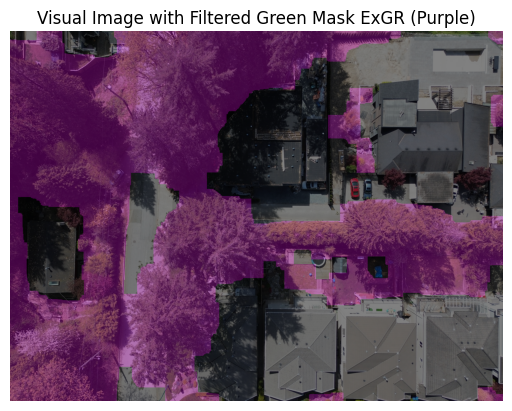

In [70]:
# Display the visual image
plt.imshow(visual_image)
plt.title("Visual Image with Filtered Green Mask ExGR (Purple)")

# Overlay the mask with 50% transparency
plt.imshow(mask_overlay, alpha=0.5)

# Show the plot
plt.axis('off')
plt.show()


In [71]:
binary_mask = np.where(green_mask == 1, 1, 0).astype(np.uint8)

# Find contours in the opened mask
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)

# Create a new mask to draw filtered contours
contour_filtered_mask = np.zeros_like(green_mask)

for contour in contours:
    # Calculate the bounding rectangle for the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Calculate the aspect ratio and solidity
    aspect_ratio = float(w) / h
    area = cv2.contourArea(contour)
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0

    # Filter based on aspect ratio and solidity
    # Rectangular objects typically have aspect ratio close to 1 and high solidity
    if not (0.9 <= aspect_ratio <= 1.1 and solidity > 0.9):
        # Draw the contour on the filtered mask
        cv2.drawContours(contour_filtered_mask, [contour],
                         -1,
                         1,
                         thickness=cv2.FILLED)

# Apply the filtered mask to the mask overlay
mask_overlay = np.zeros_like(visual_image)
mask_overlay[:, :, 0] = 128  # Red channel for purple
mask_overlay[:, :, 1] = 0  # Green channel for purple
mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the filtered mask to the mask overlay
mask_overlay[contour_filtered_mask == 0] = [
    0, 0, 0
]  # Transparent where mask is not applied


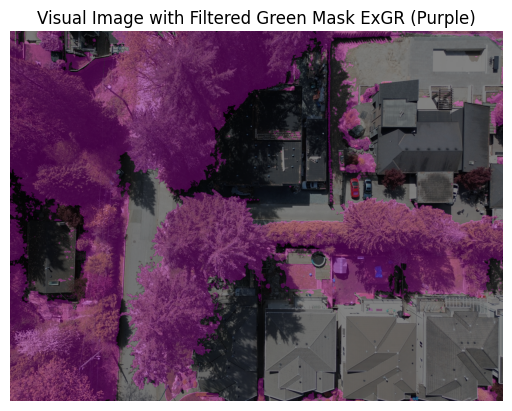

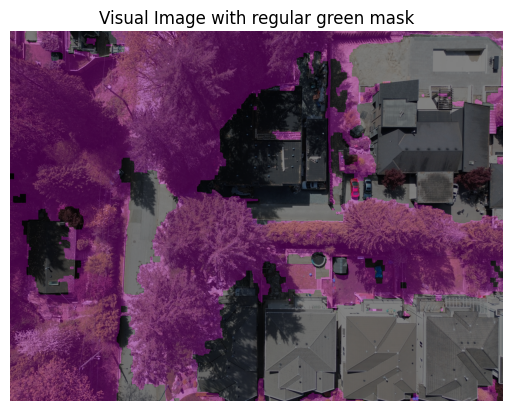

In [72]:
# Display the visual image
plt.imshow(visual_image)
plt.title("Visual Image with Filtered Green Mask ExGR (Purple)")

# Overlay the mask with 50% transparency
plt.imshow(mask_overlay, alpha=0.5)

# Show the plot
plt.axis('off')
plt.show()

# Display the visual image
plt.imshow(visual_image)
plt.title("Visual Image with regular green mask")

# Overlay the mask with 50% transparency
plt.imshow(green_mask_overlay, alpha=0.5)

# Show the plot
plt.axis('off')
plt.show()


In [128]:
from skimage.feature import local_binary_pattern

# Parameters for LBP
radius = 5
n_points = 8 * radius
METHOD = 'uniform'

# Compute LBP for the green band
lbp = local_binary_pattern(green, n_points, radius, METHOD)


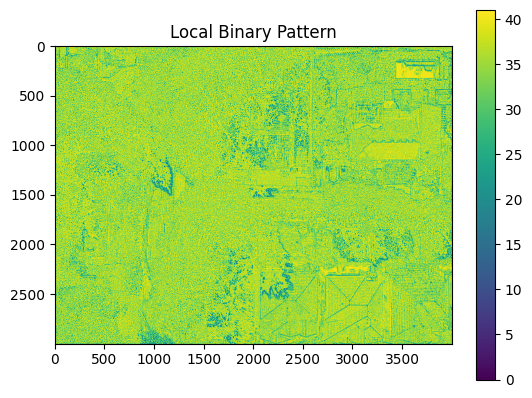

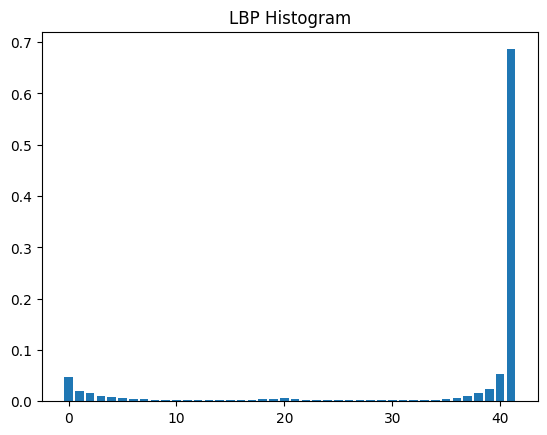

In [129]:
# Display the LBP image
plt.imshow(lbp, cmap='viridis')
plt.title('Local Binary Pattern')
plt.colorbar()
plt.show()

# Calculate LBP histogram over the entire image
lbp_hist, _ = np.histogram(lbp.ravel(),
                           bins=np.arange(0, n_points + 3),
                           range=(0, n_points + 2))
lbp_hist = lbp_hist.astype('float')
lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize the histogram

# Display the LBP histogram
plt.bar(np.arange(len(lbp_hist)), lbp_hist)
plt.title('LBP Histogram')
plt.show()

LBP Variance: 24.50


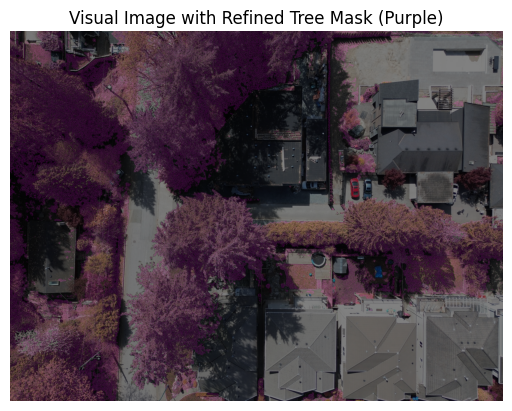

In [125]:
# Create a refined mask combining GRVI and LBP features
# Use the 75th percentile of LBP values as a threshold for tree-like textures
lbp_var = 24.5

print(f'LBP Variance: {lbp_var:.2f}')
refined_tree_mask = (green_mask == 1) & (lbp > lbp_var)

# Create a mask overlay with purple color (Red + Blue)
mask_overlay = np.zeros_like(np.dstack((blue, green, red)))
mask_overlay[:, :, 0] = 128  # Red channel for purple
mask_overlay[:, :, 1] = 0  # Green channel for purple
mask_overlay[:, :, 2] = 128  # Blue channel for purple

# Apply the refined mask to the mask overlay
mask_overlay[refined_tree_mask == 0] = [
    0, 0, 0
]  # Transparent where mask is not applied

# Display the visual image
visual_image = np.dstack((blue, green, red))
plt.imshow(visual_image)
plt.title("Visual Image with Refined Tree Mask (Purple)")

# Overlay the mask with 50% transparency
plt.imshow(mask_overlay, alpha=0.5)

# Show the plot
plt.axis('off')
plt.show()


In [ ]:
# given certain limitations of system (80m altitude, size of a tree IRL, etc.), we can give min/max size of tree
# do morphological operations to get rid of small objects and close gaps in the mask
# this way we dont falsely count small objects as trees (ie bushes, etc.) and flasely count large objects as multiple trees (ie a forest as multiple trees or a field as a single tree)

# show this with many NADIR examples, randomly sampling a city (do we show how we randomly sample a city?)
# show calculation of a footprint of a scene
# tell how many scenes like this need to cover the city
# how many trees are in the city
# how many pixels for a tree by context of a scene (altitude, height of a tree, size of a pixel, size of a tree, etc.)
# give a range for carbon absorbed by trees in the city
# estimate the carbon absorbed for the avergae scene
# estimate the carbon absorbed for the city (and bounds)
# give estimate for carbon emitted by the city
# give net carbon absorbed by the city
# is the city carbon positive or carbon negative?
# how many trees would need to be planted to offset the carbon emitted by the city?
# explain how this is a rough estimate and how it can be improved
# it can be improved by using higher resolution images, more accurate tree detection algorithms, etc.
# it can be improved by using more accurate carbon absorption rates, etc.
# it can be improved by knowing the type of tree (ie classifying the tree) and using the correct carbon absorption rate for that tree